# Finding optimal learning rate

TensorFlow 2.X implementation of finding the optimal learning rate, based on the paper _Cyclical learning rates for training neural networks_, and the `lr_find()` implementation in `fastai` for PyTorch.

### References
1. https://fastai1.fast.ai/callbacks.lr_finder.html
2. https://arxiv.org/abs/1506.01186
3. https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
4. https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import math

In [4]:
import tensorflow as tf

> **Note** Below code is only for using experimental release candidate version of [TensorFlow](https://github.com/apple/tensorflow_macos) on macOS 11.0, which allows GPU acceleration using MLCompute

In [5]:
# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
from tensorflow.python.compiler.mlcompute import mlcompute

# Select CPU device.
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and ‘any'.

In [8]:
((X_train, y_train), (X_test, y_test)) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

Model is defined without final softmax layer, so as to have access to logits directly

In [9]:
class MiniVGGNet:
    def build_model(self, width: int, height: int, depth: int, n_classes: int):
        input_shape = (width, height, depth)
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Conv2D(
                    32, (3, 3), padding="same", input_shape=input_shape
                ),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.BatchNormalization(axis=-1),
                tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.BatchNormalization(axis=-1),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Dropout(0.25),
                # Second block
                tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.BatchNormalization(axis=-1),
                tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.BatchNormalization(axis=-1),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Dropout(0.25),
                # Final block
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512),
                tf.keras.layers.Activation("relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(0.5),
                # Output
                tf.keras.layers.Dense(n_classes),
            ]
        )
        return model

To find the optimal learning rate, we need to train the model for a small number of epochs, typically 3 - 5, but with each batch / step of training, increase the learning rate. The learning rate should increase as part of a geometric series, rather than arithmetic, from a lower to upper bound, with the number of elements equal to the number of training steps needed for the number of epochs we will choose to train for. As a result, we need to find the **common ratio** for a geometric series that satisfies the above requirements.

## Geometric series
A geometric series is defined by it's starting value, $a$, and the common ratio, $r$.
$$
a_{n} = a_{n-1}\times r \\
a = {a, ar, ar^{2}, ar^{3}, ar^{4}, ... , ar^{n}}
$$
The common ratio can be found by dividing two successive elements of the series:
$$
r = \frac{a_{n}}{a_{n-1}}
$$
To find the common ratio that satisfies the above requirements, we can derive an equation, where $k$ equals the number of elements we want in the series.

If we divide the last element, $a_{N_{e}}$, by the first element, $a_{N_{s}}$, we get $r^{k}$
$$
k = N_{e} - N_{s} \\
r^{k} = \frac{a_{N_{e}}}{a_{N_{s}}} = \frac{ar^{N_{e}}}{ar^{N_{s}}} \\
r^{k} = r^{N_{e}-N_{s}} \\
$$

If we substitute the right-hand side value of $r^{k}$ with a numerical value, $A$, we can solve for $r$, with the value of $k$ we want:

$$
k\cdot\log{r}=\log{A} \\
\log{r} = \frac{\log{A}}{k} \\
r = 10^{\frac{\log{A}}{k}}
$$

This equation is not necessary if we are using `np.geomspace()`.

## Learning rate finder

In [57]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr: float, max_lr: float, steps: int):
        super(LearningRateFinder, self).__init__()
        self.batch_num = 0
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lr_range = np.geomspace(self.min_lr, self.max_lr, steps)
        self.history = []

    def on_train_batch_end(self, batch: int, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.history.append(
            {
                "batch": self.batch_num,
                "lr": self.lr_range[self.batch_num],
                "loss": logs["loss"],
            }
        )
        self.batch_num += 1
        if not self.batch_num == self.steps:
            tf.keras.backend.set_value(
                self.model.optimizer.lr, self.lr_range[self.batch_num]
            )

Choose a small number of epochs between 3 - 5.

In [58]:
BATCH_SIZE = 24
N_EPOCHS = 3

In [59]:
STARTING_LEARNING_RATE = 1e-10
lr_find = LearningRateFinder(
    min_lr=STARTING_LEARNING_RATE,
    max_lr=1e1,
    steps=N_EPOCHS * math.ceil(X_train.shape[0] / BATCH_SIZE),
)

In [60]:
model = MiniVGGNet().build_model(width=28, height=28, depth=1, n_classes=10)
sgd = tf.optimizers.SGD(
    learning_rate=STARTING_LEARNING_RATE,
)
model.compile(
    optimizer=sgd,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

In [61]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, callbacks=[lr_find])

Epoch 1/3
2500/2500 [==============================] - 56s 22ms/step - loss: 3.7293
Epoch 2/3
2500/2500 [==============================] - 55s 22ms/step - loss: 3.5165
Epoch 3/3
2500/2500 [==============================] - 57s 23ms/step - loss: nan


In [62]:
history = pd.DataFrame(lr_find.history)

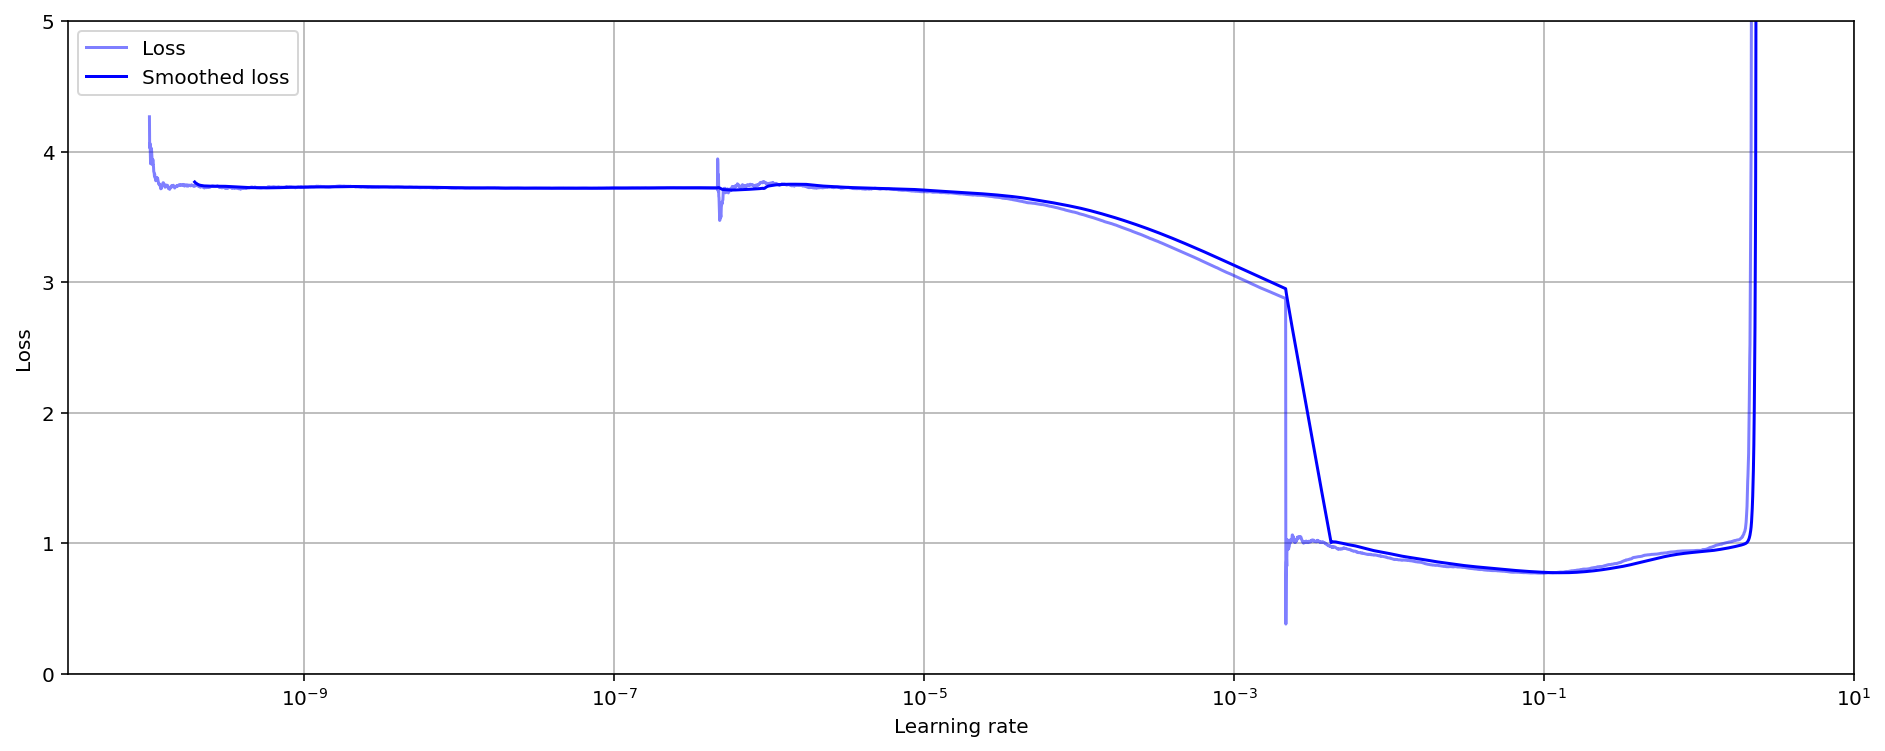

In [85]:
f, ax = plt.subplots(figsize=(16, 6))
ax.plot(history.lr, history.loss, alpha=0.5, c="b", label="Loss")
ax.plot(history.lr, history.loss.rolling(200).mean(), c="b", label="Smoothed loss")
ax.set_ylim([0, 5])
ax.set_ylabel("Loss")
ax.set_xlabel("Learning rate")
ax.set_xscale("log")
ax.legend()
ax.grid("on")

The minimum of this graph is at a learning rate of $10^{-1}$, but in fact this is not the best learning rate as we are too close to a learning rate that can cause an explosion in loss. Hence, it is best to go back one order of magnitude.